===========================================================
Manual Generalized Additive Model (GAM) Implementation
-----------------------------------------------------------
Author: Patrick Baghdasarian
Date: 2025
Description:
    This script builds a GAM estimation framework from scratch.
    It reads yield data from CSV files, computes descriptive
    statistics, constructs spline bases, fits penalized IRLS
    models, and visualizes results.

Features:
    - Reads multiple CSVs automatically.
    - Computes dataset summaries and correlations.
    - Supports multiple spline types:
        * B-spline
        * Natural cubic spline
        * Thin-plate spline (approximate)
        * Cubic regression spline
    - Supports multiple link families:
        * Gaussian (identity)
        * Poisson (log)
        * Binomial (logit)
    - Implements full penalized IRLS estimation loop.
    - Prints condition numbers for diagnostics.
    - Plots fitted vs observed data.

Dependencies:
    numpy, pandas, matplotlib, scipy, patsy
===========================================================
"""

In [2]:
"""
===========================================================
Manual Generalized Additive Model (GAM) Framework
===========================================================
Author: Patrick Baghdasarian
Description:
    - Loads yield data from CSV
    - Builds spline basis + penalty matrices
    - Fits penalized GAMs (shared & by-Product smooths)
    - Captures and exports iterative matrices
    - Generates PDF diagnostic reports automatically
===========================================================
"""

# ============================================================
# Imports and Dependencies
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as si
from patsy import dmatrix
from numpy.linalg import cond, LinAlgError
import os, json
from datetime import datetime

# Auto-install reportlab if not present
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet
except ImportError:
    os.system('pip install reportlab')
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet


In [3]:
# ============================================================
# 1. Load Data and Descriptive Stats
# ============================================================
def load_yield_data(*filepaths):
    dfs = []
    for f in filepaths:
        print(f"\n📥 Loading {f} ...")
        df = pd.read_csv(f)
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    print("\n✅ Combined dataset shape:", data.shape)
    print("\n📋 Columns:", list(data.columns))
    print("\n📊 Descriptive statistics:\n", data.describe(include='all'))
    if 'Yield' in data.columns and 'Product' in data.columns:
        print("\n📦 Mean Yield by Product:\n", data.groupby('Product')['Yield'].mean())
    return data


In [4]:
# ============================================================
# 2. Spline Basis and Penalty Matrix Functions
# ============================================================
def bspline_basis(x, knots, degree=3):
    n_basis = len(knots) + degree - 1
    X = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        c = np.zeros(n_basis)
        c[i] = 1
        spline = si.BSpline(knots, c, degree, extrapolate=True)
        X[:, i] = spline(x)
    return X

def bspline_penalty(knots, degree=3, order=2):
    xx = np.linspace(knots[0], knots[-1], 400)
    n_basis = len(knots) + degree - 1
    B2 = np.zeros((len(xx), n_basis))
    for i in range(n_basis):
        c = np.zeros(n_basis)
        c[i] = 1
        spline = si.BSpline(knots, c, degree, extrapolate=True)
        B2[:, i] = spline(xx, order)
    return B2.T @ B2 * (xx[1] - xx[0])

def natural_cubic_basis(x, knots):
    X = np.asarray(dmatrix("cr(x, knots=knots)", {"x": x}, return_type='dataframe'))
    S = np.eye(X.shape[1])
    return X, S

def thin_plate_basis(x, k=10):
    x = x[:, None]
    knots = np.linspace(x.min(), x.max(), k)
    r = np.abs(x - knots)
    X = r**2 * np.log(r + 1e-8)
    X -= X.mean(axis=0)
    S = X.T @ X
    return X, S

def cubic_regression_basis(x, knots):
    X = np.asarray(dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
                           {"x": x}, return_type='dataframe'))
    D2 = np.diff(np.eye(X.shape[1]), n=2, axis=0)
    S = D2.T @ D2
    return X, S

def build_spline_basis(x, spline_type="bspline", knots=None, degree=3):
    if knots is None:
        knots = np.linspace(x.min(), x.max(), 10)
    if spline_type == "bspline":
        X = bspline_basis(x, knots, degree)
        S = bspline_penalty(knots, degree)
    elif spline_type == "natural_cubic":
        X, S = natural_cubic_basis(x, knots)
    elif spline_type == "thin_plate":
        X, S = thin_plate_basis(x, k=len(knots))
    elif spline_type == "cr_spline":
        X, S = cubic_regression_basis(x, knots)
    else:
        raise ValueError(f"Unknown spline_type: {spline_type}")
    print(f"✅ Built {spline_type} basis with shape {X.shape}")
    return X, S

In [5]:
# ============================================================
# 3. Family Specifications
# ============================================================
def family_spec(family):
    if family == "gaussian":
        return {"link": lambda mu: mu, "inv": lambda eta: eta,
                "var": lambda mu: np.ones_like(mu), "gprime": lambda mu: np.ones_like(mu)}
    elif family == "poisson":
        return {"link": np.log, "inv": np.exp,
                "var": lambda mu: mu, "gprime": lambda mu: 1/mu}
    elif family == "binomial":
        return {"link": lambda mu: np.log(mu/(1-mu)),
                "inv": lambda eta: 1/(1+np.exp(-eta)),
                "var": lambda mu: mu*(1-mu), "gprime": lambda mu: 1/(mu*(1-mu))}
    else:
        raise ValueError("Unsupported family")

In [6]:
# ============================================================
# 4. Robust Penalized IRLS (with Matrix Capture + Save)
# ============================================================
def penalized_irls(y, X, S, lam=10, family="gaussian", max_iter=30, tol=1e-6,
                   eps=1e-6, capture=True, save_iter_matrices=True,
                   output_dir="diagnostics"):
    fam = family_spec(family)
    beta = np.zeros(X.shape[1])
    eta = X @ beta
    mu = fam["inv"](eta)

    # Create timestamped folder
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_path = os.path.join(output_dir, f"diagnostics_{timestamp}")
    os.makedirs(save_path, exist_ok=True)
    print(f"\n📂 Saving diagnostics to: {save_path}")

    # Initialize trace storage
    trace = {"W": [], "XTWX": [], "Penalized": [],
             "Cond_XWX": [], "Cond_S": [], "Cond_Penalized": [], "Beta": []}

    print("\nStarting IRLS fitting...")
    for it in range(max_iter):
        z = eta + (y - mu) * fam["gprime"](mu)
        W = np.diag(1 / (fam["var"](mu) * fam["gprime"](mu)**2))
        XTWX = X.T @ W @ X
        penalized = XTWX + lam * S + eps * np.eye(S.shape[0])

        cond_XWX = cond(XTWX)
        cond_S = cond(S)
        cond_pen = cond(penalized)
        print(f"Iter {it}: cond(X'WX)={cond_XWX:.2e}, cond(S)={cond_S:.2e}, cond(penalized)={cond_pen:.2e}")

        if cond_pen > 1e10:
            print("⚠️ Warning: Penalized matrix near singular, ridge correction applied.")

        # Store matrices
        if capture:
            trace["W"].append(W.copy())
            trace["XTWX"].append(XTWX.copy())
            trace["Penalized"].append(penalized.copy())
            trace["Cond_XWX"].append(cond_XWX)
            trace["Cond_S"].append(cond_S)
            trace["Cond_Penalized"].append(cond_pen)
            trace["Beta"].append(beta.copy())

        # Save matrices
        np.save(os.path.join(save_path, f"W_iter_{it}.npy"), W)
        np.save(os.path.join(save_path, f"XTWX_iter_{it}.npy"), XTWX)
        np.save(os.path.join(save_path, f"Penalized_iter_{it}.npy"), penalized)
        with open(os.path.join(save_path, f"Cond_iter_{it}.json"), "w") as f:
            json.dump({"Cond_XWX": float(cond_XWX),
                       "Cond_S": float(cond_S),
                       "Cond_Penalized": float(cond_pen)}, f, indent=2)

        # Solve
        b = X.T @ W @ z
        try:
            beta_new = np.linalg.solve(penalized, b)
        except LinAlgError:
            print("⚠️ Singular matrix encountered, using pseudo-inverse instead.")
            beta_new = np.linalg.pinv(penalized) @ b

        # Convergence
        delta = np.linalg.norm(beta_new - beta)
        if delta < tol:
            print(f"✅ Converged at iteration {it} (Δβ={delta:.2e})")
            break

        beta = beta_new
        eta = X @ beta
        mu = fam["inv"](eta)

    # Save final state
    np.save(os.path.join(save_path, "Final_Beta.npy"), beta)
    np.save(os.path.join(save_path, "Final_Mu.npy"), mu)
    with open(os.path.join(save_path, "TraceSummary.json"), "w") as f:
        json.dump({"iterations": it+1, "final_cond_penalized": float(cond_pen),
                   "family": family, "lambda": lam}, f, indent=2)

    return beta, mu, W, trace, save_path

In [7]:
# ============================================================
# 5. PDF Report Generator
# ============================================================
def generate_pdf_summary(save_dir, family, spline_type, lam, trace1, trace2, x, y, mu1, mu2):
    pdf_path = os.path.join(save_dir, "GAM_Diagnostics_Report.pdf")
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    elements = []

    elements.append(Paragraph("<b>Generalized Additive Model Diagnostics</b>", styles['Title']))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(f"Family: {family}", styles['Normal']))
    elements.append(Paragraph(f"Spline Type: {spline_type}", styles['Normal']))
    elements.append(Paragraph(f"Lambda (λ): {lam}", styles['Normal']))
    elements.append(Spacer(1, 12))

    # --- Fit plot ---
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, s=15, color='gray', alpha=0.7, label="Observed")
    plt.plot(x, mu1, 'r', lw=2, label="Model 1: shared smooth")
    plt.plot(x, mu2, 'b', lw=2, label="Model 2: by=Product")
    plt.legend(); plt.xlabel("Northing"); plt.ylabel("Yield")
    plt.title(f"GAM Fit (family={family}, spline={spline_type})")
    fit_img = os.path.join(save_dir, "fit_plot.png")
    plt.savefig(fit_img, dpi=150, bbox_inches="tight"); plt.close()
    elements.append(Image(fit_img, width=450, height=300))
    elements.append(Spacer(1, 12))

    # --- Condition number plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(trace1["Cond_Penalized"], 'r', label="Shared Smooth")
    plt.plot(trace2["Cond_Penalized"], 'b', label="By-Product Smooth")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Condition Number (log)")
    plt.legend(); plt.title("Condition Number Evolution")
    cond_img = os.path.join(save_dir, "condition_numbers.png")
    plt.savefig(cond_img, dpi=150, bbox_inches="tight"); plt.close()
    elements.append(Image(cond_img, width=450, height=300))
    elements.append(Spacer(1, 12))

    # --- Summary text ---
    summary = f"""
    <b>Summary:</b><br/>
    Iterations (shared): {len(trace1['Cond_Penalized'])}<br/>
    Iterations (by-product): {len(trace2['Cond_Penalized'])}<br/>
    Final cond (shared): {trace1['Cond_Penalized'][-1]:.3e}<br/>
    Final cond (by-product): {trace2['Cond_Penalized'][-1]:.3e}<br/>
    Saved folder: {save_dir}
    """
    elements.append(Paragraph(summary, styles['Normal']))

    doc.build(elements)
    print(f"📄 PDF summary saved to: {pdf_path}")

In [8]:
# ============================================================
# 6. fit_gam() Main Function
# ============================================================
def fit_gam(data, spline_type="bspline", family="gaussian", lam=100):
    x = data["Northing"].values
    y = data["Yield"].values
    product = data["Product"].values if "Product" in data.columns else np.repeat("A", len(y))

    knots = np.linspace(x.min(), x.max(), 10)
    X, S = build_spline_basis(x, spline_type=spline_type, knots=knots)

    print(f"\n📘 Fitting Model 1 (shared smooth)...")
    beta1, mu1, W1, trace1, save_path = penalized_irls(y, X, S, lam=lam, family=family)

    print(f"\n📘 Fitting Model 2 (by-Product smooths)...")
    maskA = (product == np.unique(product)[0]).astype(float)
    maskB = (product == np.unique(product)[1]).astype(float)
    X_A = X * maskA[:, None]
    X_B = X * maskB[:, None]
    X_by = np.concatenate([X_A, X_B], axis=1)
    S_block = np.block([[S, np.zeros_like(S)], [np.zeros_like(S), S]])
    beta2, mu2, W2, trace2, _ = penalized_irls(y, X_by, S_block, lam=lam, family=family)

    # Plot and PDF summary
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=15, color='gray', alpha=0.7, label="Observed")
    plt.plot(x, mu1, 'r', lw=2, label="Model 1: shared smooth")
    plt.plot(x, mu2, 'b', lw=2, label="Model 2: by=Product")
    plt.title(f"GAM (family={family}, spline={spline_type})")
    plt.xlabel("Northing"); plt.ylabel("Yield"); plt.legend()
    plt.show()

    generate_pdf_summary(save_path, family, spline_type, lam, trace1, trace2, x, y, mu1, mu2)
    return beta1, beta2, W1, W2, trace1, trace2


📥 Loading Example1SmoothHarvestStrip214.csv ...

✅ Combined dataset shape: (24, 8)

📋 Columns: ['Yield', 'Easting', 'PassNo', 'Pair', 'Product', 'Northing', 'Pass', 'Predicted']

📊 Descriptive statistics:
              Yield  Easting     PassNo       Pair Product    Northing  \
count    24.000000     24.0  24.000000  24.000000      24   24.000000   
unique         NaN      NaN        NaN        NaN       2         NaN   
top            NaN      NaN        NaN        NaN       E         NaN   
freq           NaN      NaN        NaN        NaN      12         NaN   
mean    168.353013    214.0  12.500000   6.500000     NaN   70.779935   
std      21.055921      0.0   7.071068   3.526299     NaN   43.001776   
min     133.427918    214.0   1.000000   1.000000     NaN    0.783073   
25%     158.071998    214.0   6.750000   3.750000     NaN   35.817419   
50%     169.499280    214.0  12.500000   6.500000     NaN   70.748124   
75%     186.634507    214.0  18.250000   9.250000     NaN  105.

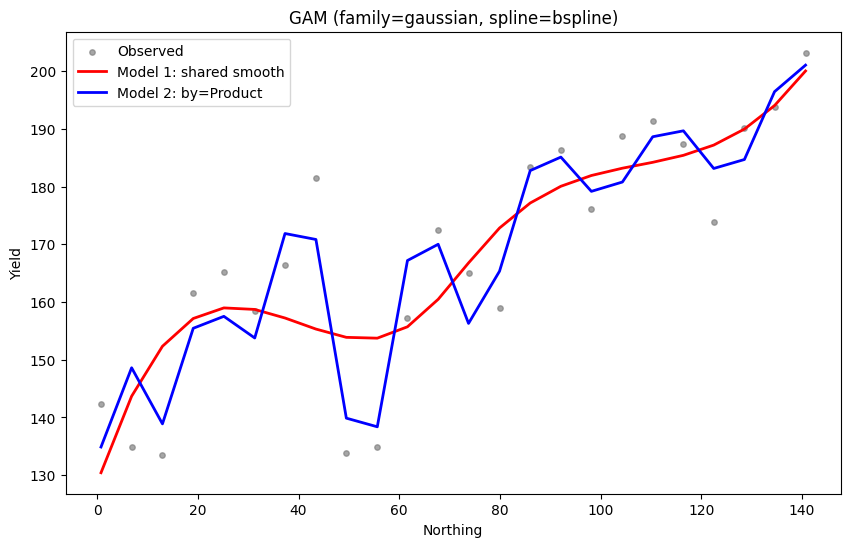

📄 PDF summary saved to: diagnostics/diagnostics_2025-10-21_13-54-32/GAM_Diagnostics_Report.pdf


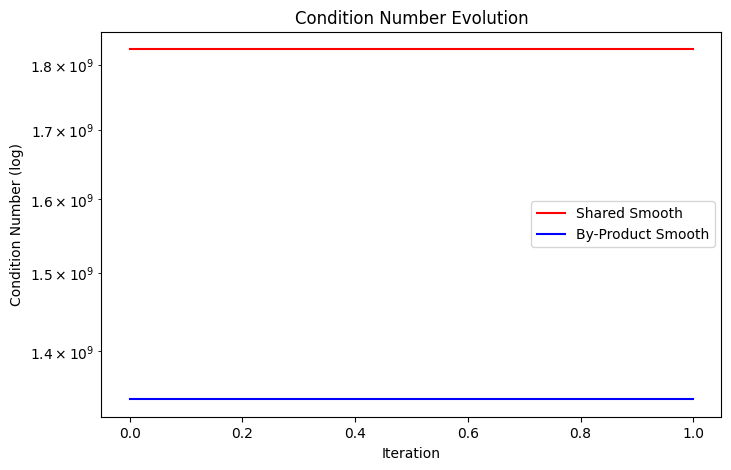

Example W matrix (shared smooth, iteration 2):
⚠️ Only 2 iterations recorded — model converged early.
Here’s the last available W matrix instead:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
# ============================================================
# 7. Execution
# ============================================================
if __name__ == "__main__":
    data = load_yield_data(
        "Example1SmoothHarvestStrip214.csv"
    )

    beta1, beta2, W1, W2, trace1, trace2 = fit_gam(
        data,
        spline_type="bspline",
        family="gaussian",
        lam=100
    )

    plt.figure(figsize=(8, 5))
    plt.plot(trace1["Cond_Penalized"], 'r', label="Shared Smooth")
    plt.plot(trace2["Cond_Penalized"], 'b', label="By-Product Smooth")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Condition Number (log)")
    plt.legend(); plt.title("Condition Number Evolution"); plt.show()

    print("Example W matrix (shared smooth, iteration 2):")

if len(trace1["W"]) > 2:
    print(trace1["W"][2])
else:
    print(f"⚠️ Only {len(trace1['W'])} iterations recorded — model converged early.")
    print("Here’s the last available W matrix instead:")
    print(trace1["W"][-1])


The code above is a lot to unpack. We'll now try to step through it. First, we define data tables for three cases. We want fit a generalized additive model of the form
$$
Yield{i} = Product_{i} + f(Northing_i) + \epsilon
$$
where $f$ is a smoothing function of the form
f(Northing_i) = \sum_{j=1}^k \beta_j B_j(Northing_i)
with $\beta_j$ being coefficients to be found be P-IRLS and $B_j$ being a basis function. The set of $k$ basis functions are evaluated at each of the elements of $Northing_i$; each $B_j$ corresponds to the a column of the design matrix $X$.

This determines how we define the data tables = each contrains the columns 
- `Yield` 
  - Estimate from a smoothing function of corn harvest over strips
-  `Product`
  - An indicator variable that is 0 for product B and 1 for product E
- `Northing` 
  - A position in space as distance from the south border of the field.
  

In [10]:
import pandas

Yield214 = pandas.DataFrame(
  {"Yield" : [142.30999016112, 134.816631390101, 133.427917773201, 161.481654793547, 165.271076641428, 158.365568915447,
          166.495294761056, 181.416059276517, 133.903642716581, 134.81774322369, 157.191283964691, 172.503265011261,
          165.112451330955, 158.903795932606, 183.319650297151, 186.357485025453, 176.135437423899, 188.849845511496,
          191.304313015102, 187.465572345687, 173.793504062, 190.236566631752, 193.796227256552, 203.197339018491],
  "Product" : ["E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B",
            "E", "E", "B", "B"],
  "Northing" : [0.783072959421157, 6.8630408585656, 12.9852964518518, 19.0984345227862, 25.1816935720809, 
             31.3085784454595, 37.320366207733, 43.4594654812367, 49.4976038696288, 55.6446310137961, 
             61.6350571132918, 67.7339494941491, 73.7622992709295, 79.9142402925501, 86.0080040887833, 
             92.093686219178, 98.1548134744314, 104.314751055382, 110.340220433542, 116.426924809464, 
             122.447750322627, 128.540554585316, 134.522876331975, 140.681138361472]
  }
)
Yield216 = pandas.DataFrame(
  {"Yield" : [139.226769807541, 131.535935351134, 129.140773440201, 156.491482634976, 163.636680369683, 
            156.161889299633, 165.861947713099, 180.21979467059, 132.06574725736, 133.005306604335, 
            156.961068484051, 173.256663183778, 164.792329964379, 159.063216126603, 182.33180291636, 
            185.075272348869, 174.52824925003, 187.32511712949, 189.860309540485, 186.671392327381, 
            174.971929918947, 192.247442350469, 194.586351881239, 204.649772439691],
  "Product" : ["E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", 
            "B", "B", "E", "E", "B", "B"],
  "Northing" : [0.783072959421157, 6.8630408585656, 12.9852964518518, 19.0984345227862, 25.1816935720809, 
             31.3085784454595, 37.320366207733, 43.4594654812367, 49.4976038696288, 55.6446310137961, 
             61.6350571132918, 67.7339494941491, 73.7622992709295, 79.9142402925501, 86.0080040887833, 
             92.093686219178, 98.1548134744314, 104.314751055382, 110.340220433542, 116.426924809464, 
             122.447750322627, 128.540554585316, 134.522876331975, 140.681138361472]
  }
)
Yield218 = pandas.DataFrame(
  {"Yield" : [136.3645, 128.5203, 125.2104, 151.7673, 162.1232, 154.0905, 165.4766, 179.2397, 130.6581, 
            131.5777, 156.9808, 174.0609, 164.5684, 159.2720, 181.3242, 183.6998, 172.9337, 185.6536, 
            188.3372, 185.7617, 176.0440, 194.1953, 195.3868, 206.0945],
  "Product" : ["E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", "B", "B", "E", "E", 
            "B", "B", "E", "E", "B", "B"], 
  "Northing" : [0.783073, 6.863041, 12.985296, 19.098435, 25.181694, 31.308578, 37.320366, 43.459465, 
              49.497604, 55.644631, 61.635057, 67.733949, 73.762299, 79.914240, 86.008004, 92.093686,
              98.154813, 104.314751, 110.340220, 116.426925, 122.447750, 128.540555, 134.522876, 140.681138]
  }
)

Now, we build a b-spline bases, starting with Yield214. First, we extract values from the data frame into lists following from fit_gam

In [11]:
x = Yield214["Northing"].values
y = Yield214["Yield"].values
product = data["Product"].values
#fit_gam defaults to 10 knots
knots = np.linspace(x.min(), x.max(), 10)
knots

array([  0.78307296,  16.32730245,  31.87153194,  47.41576143,
        62.95999092,  78.50422041,  94.04844989, 109.59267938,
       125.13690887, 140.68113836])

Now, let's see what build_spline_basis does.

In [12]:
X, S = build_spline_basis(x, spline_type="bspline", knots=knots)
# error for this data
# X, S = build_spline_basis(x, spline_type="natural_cubic", knots=knots)

X[:,1]

✅ Built bspline basis with shape (24, 12)


array([-2.18333333e+01, -1.50176327e+01, -9.67319999e+00, -5.67488683e+00,
       -2.84255645e+00, -9.63392952e-01,  1.07892853e-01,  5.93643111e-01,
        6.49930531e-01,  4.60598366e-01,  2.12607844e-01,  5.54397207e-02,
        4.73155760e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

Visualize the $X$ and $S$ matrices

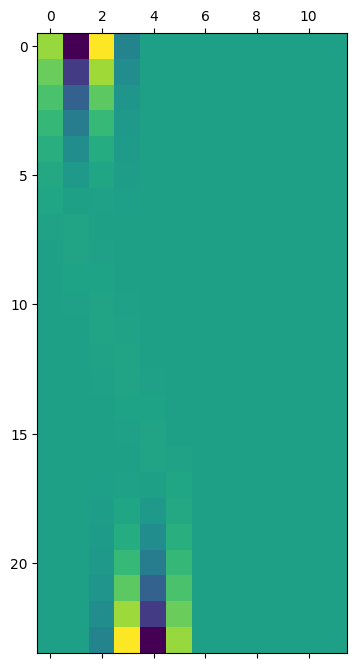

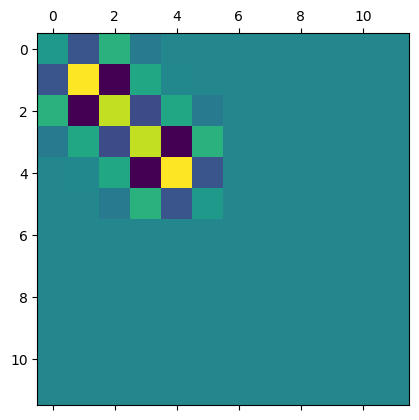

In [13]:
plt.matshow(X, cmap='viridis')

plt.matshow(S, cmap='viridis')

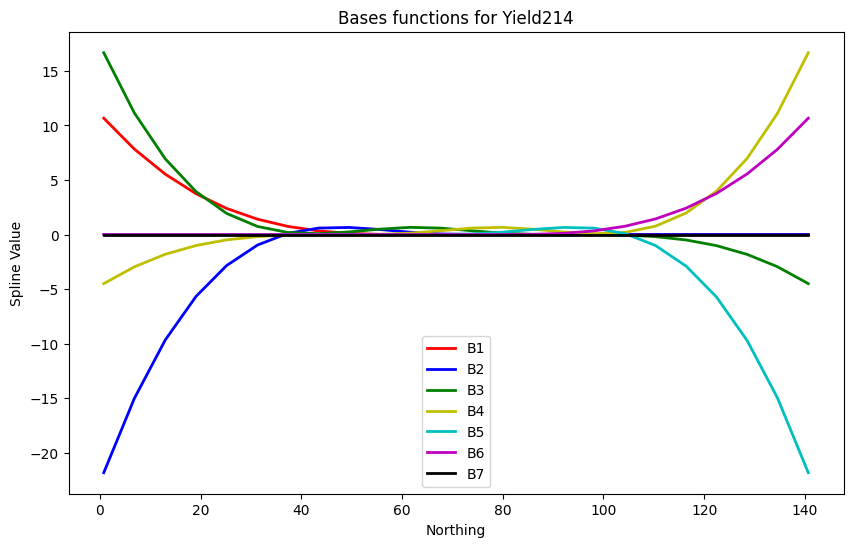

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(x, X[:,0], 'r', lw=2, label="B1")
plt.plot(x, X[:,1], 'b', lw=2, label="B2")
plt.plot(x, X[:,2], 'g', lw=2, label="B3")
plt.plot(x, X[:,3], 'y', lw=2, label="B4")
plt.plot(x, X[:,4], 'c', lw=2, label="B5")
plt.plot(x, X[:,5], 'm', lw=2, label="B6")
plt.plot(x, X[:,6], 'k', lw=2, label="B7")
plt.title("Bases functions for Yield214")
plt.xlabel("Northing"); plt.ylabel("Spline Value"); plt.legend()
plt.show()


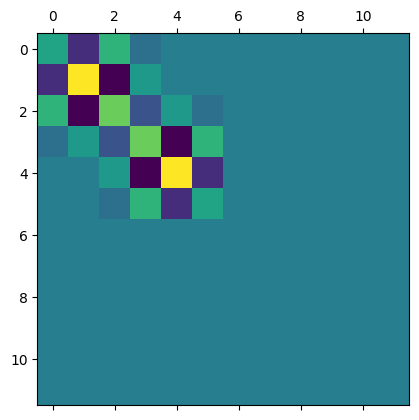

In [15]:
Xt = np.transpose(X)
XtX = np.matmul(Xt, X)
#plt.matshow(XtX, cmap='viridis')
plt.matshow(XtX)

What is going on with the by-`Product` matrices? We duplice the code from fit_gam


In [16]:
maskA = (product == np.unique(product)[0]).astype(float)
maskB = (product == np.unique(product)[1]).astype(float)
X_A = X * maskA[:, None]
X_B = X * maskB[:, None]
X_by = np.concatenate([X_A, X_B], axis=1)
S_block = np.block([[S, np.zeros_like(S)], [np.zeros_like(S), S]])
#beta2, mu2, W2, trace2, _ = penalized_irls(y, X_by, S_block, lam=lam, family=family)

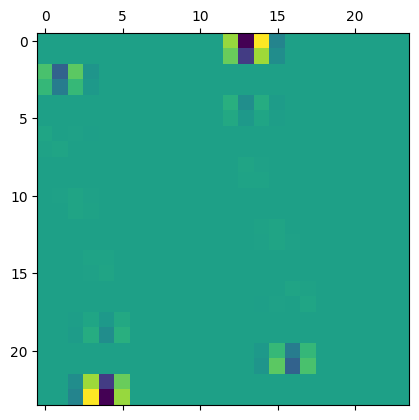

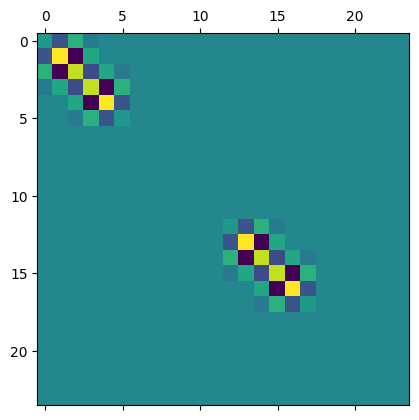

In [17]:
plt.matshow(X_by, cmap='viridis')
plt.matshow(S_block, cmap='viridis')

In [18]:
β=1
β

1